In [1]:
###### sampling code (optional)
from pathlib import Path
import pandas as pd

# Edit paths if needed
JEOPARDY_PATH = Path("./dataset.csv")
  # optional

def load_csv(path, **kwargs):
    if path.exists():
        return pd.read_csv(path, **kwargs)
    print(f"Warning: {path} not found.")
    return None

jeopardy = load_csv(JEOPARDY_PATH)


# ====== (Optional) Sampling ======
# Leave all values as None to use the full dataset.
SAMPLE = {
    "jeopardy": {"n": None, "frac": None, "random_state": None, "stratify_col": None},  # e.g., {"n": 20000, "random_state": 42}
    
}

def maybe_sample(df, cfg):
    """Return sampled df if n/frac set; otherwise return df. Optional stratify by a column name."""
    if df is None:
        return None
    n, frac, rs, strat = cfg.get("n"), cfg.get("frac"), cfg.get("random_state"), cfg.get("stratify_col")
    if strat and strat in df.columns and (n or frac):
        # stratified sampling (simple & proportional when using frac)
        if frac:
            return (df.groupby(strat, group_keys=False)
                      .apply(lambda g: g.sample(frac=frac, random_state=rs))
                      .reset_index(drop=True))
        # proportional n by class frequency (rounded)
        counts = df[strat].value_counts(normalize=True) * n
        parts = []
        for k, need in counts.round().astype(int).items():
            part = df[df[strat]==k].sample(n=min(need, len(df[df[strat]==k])), random_state=rs)
            parts.append(part)
        out = pd.concat(parts).reset_index(drop=True)
        return out.sample(frac=1.0, random_state=rs).reset_index(drop=True)
    # simple sampling
    if frac: return df.sample(frac=frac, random_state=rs).reset_index(drop=True)
    if n:    return df.sample(n=min(n, len(df)), random_state=rs).reset_index(drop=True)
    return df.reset_index(drop=True)

jeopardy_sample = maybe_sample(jeopardy, SAMPLE["jeopardy"])

print("Jeopardy:", None if jeopardy is None else jeopardy.shape,
      "-> sample:", None if jeopardy_sample is None else jeopardy_sample.shape)



Jeopardy: None -> sample: None


In [2]:
# %% [markdown]
# Spotify Tracks — Clustering & Analysis
#
# Notebook script to perform exploratory data analysis, feature engineering,
# dimensionality reduction, clustering, and cluster profiling on the
# `maharshipandya/spotify-tracks-dataset` (Hugging Face). Save as a Jupyter
# notebook or run as a script (cells are separated with `# %%`).

# %%
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
import umap

# %% [markdown]
# ## 1) Load dataset
# The dataset is available on Hugging Face as `maharshipandya/spotify-tracks-dataset`.
# You can either download the CSV from the Hugging Face Files tab or load it
# programmatically via `datasets` or by pointing `pd.read_csv()` to the raw file
# URL if available.

# %%
# Example: try to load from a local file first, otherwise ask the user to provide
# the path. Replace `path` with the actual CSV path when running.

default_path = "spotify-tracks-dataset/dataset.csv"  # change if you downloaded with a different name
if os.path.exists(default_path):
    print("hi")
    df = pd.read_csv(default_path, low_memory=False)
else:
    print("not hi")
    # fallback: try to load via the huggingface "datasets" library
    try:
        from datasets import load_dataset
        ds = load_dataset('maharshipandya/spotify-tracks-dataset')
        df = ds['train'].to_pandas()
    except Exception as e:
        raise RuntimeError(
            "Dataset not found locally and failed to load via `datasets`.\n"
            "Please download the CSV from Hugging Face and set `default_path` accordingly."
        )

print('loaded rows:', len(df))

# %% [markdown]
# ## 2) Quick EDA

# %%
print('\nColumn overview:')
print(df.dtypes)
print('\nSample rows:')
print(df.head(5))

# %%
# Basic stats for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns:', numeric_cols)
print(df[numeric_cols].describe().T)

# %% [markdown]
# ## 3) Cleaning & feature selection
# We'll select audio features commonly used in music analysis and clustering:
# `danceability, energy, loudness, speechiness, acousticness, instrumentalness,
# liveness, valence, tempo, duration_ms, popularity`. We'll also extract
# `track_genre` and `explicit` for profiling clusters.

# %%
features = [
    'danceability','energy','loudness','speechiness','acousticness',
    'instrumentalness','liveness','valence','tempo','duration_ms','popularity'
]
# Keep only features that exist in the dataset
features = [c for c in features if c in df.columns]
profile_cols = [c for c in ['track_genre','explicit','artists','album_name','track_name'] if c in df.columns]
print('Using features:', features)

# %%
# Drop rows missing too many features; impute remaining missing numerical values with median
sub = df[features + profile_cols].copy()
missing_fraction = sub[features].isna().mean(axis=1)
# drop rows with >50% audio feature missing
sub = sub[missing_fraction <= 0.5].reset_index(drop=True)

imputer = SimpleImputer(strategy='median')
sub[features] = imputer.fit_transform(sub[features])

print('After cleaning rows:', len(sub))

# %% [markdown]
# ## 4) Feature transformations
# - Loudness has negative values; scaling will handle that.
# - Duration (ms) and tempo may need log-scaling; we'll keep them and use robust scaling.

# %%
X_raw = sub[features].copy()
# Optional: log transform duration_ms to reduce skew
if 'duration_ms' in X_raw.columns:
    X_raw['duration_ms_log'] = np.log1p(X_raw['duration_ms'])
    X_raw.drop(columns=['duration_ms'], inplace=True)
    # replace feature list accordingly
    features_transformed = [c for c in X_raw.columns]
else:
    features_transformed = [c for c in X_raw.columns]

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
print('Feature matrix shape:', X.shape)

# %% [markdown]
# ## 5) Dimensionality reduction for visualization
# We'll compute PCA and UMAP/t-SNE for 2D embeddings to visualize clusters.

# %%
# PCA
pca = PCA(n_components=10, random_state=42)
X_pca10 = pca.fit_transform(X)
explained = pca.explained_variance_ratio_.cumsum()
print('PCA cumulative variance (10 comps):', explained)

# 2D UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_pca10)

# 2D t-SNE (optional; slower)
# from sklearn.manifold import TSNE
# X_tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42).fit_transform(X_pca10)

# Plot UMAP
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], s=6, alpha=0.6)
plt.title('UMAP projection (all tracks)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6) Clustering
# We'll attempt KMeans for a range of K and choose K using silhouette score and CH index.

# %%
ks = list(range(2,13))
km_scores = []
ch_scores = []
models = {}
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca10)
    sil = silhouette_score(X_pca10, labels)
    ch = calinski_harabasz_score(X_pca10, labels)
    km_scores.append(sil)
    ch_scores.append(ch)
    models[k] = (km, labels)
    print(f'k={k}: silhouette={sil:.4f}, CH={ch:.1f}')

# choose best K by silhouette
best_k = ks[int(np.argmax(km_scores))]
print('\nBest k by silhouette:', best_k)

# Fit chosen model and attach labels to dataframe
best_km, best_labels = models[best_k]
sub['cluster'] = best_labels

# Visualize clusters on UMAP
plt.figure(figsize=(8,6))
for c in sorted(sub['cluster'].unique()):
    mask = sub['cluster'] == c
    plt.scatter(X_umap[mask,0], X_umap[mask,1], s=8, alpha=0.6, label=f'c{c}')
plt.legend()
plt.title(f'UMAP with KMeans clusters (k={best_k})')
plt.show()

# %% [markdown]
# ## 7) Cluster profiling
# For each cluster compute feature means, top genres, explicit flag share, and popularity.

# %%
cluster_profiles = []
for c in sorted(sub['cluster'].unique()):
    dfc = sub[sub['cluster'] == c]
    profile = dfc[features].mean().to_dict()
    profile['n_tracks'] = len(dfc)
    profile['popularity_mean'] = dfc['popularity'].mean() if 'popularity' in dfc.columns else np.nan
    # top genres
    if 'track_genre' in dfc.columns:
        top_genres = dfc['track_genre'].value_counts().head(5).to_dict()
        profile['top_genres'] = top_genres
    # explicit share
    if 'explicit' in dfc.columns:
        profile['explicit_share'] = dfc['explicit'].mean()
    cluster_profiles.append((c, profile))

# show profiles in a table
profiles_df = pd.DataFrame([{'cluster':c, **p} for c,p in cluster_profiles])
print(profiles_df.sort_values('n_tracks', ascending=False).T)

# %% [markdown]
# ## 8) Deeper analyses / ideas (provided as code blocks)
# - Popularity vs. audio features scatter plots
# - Genre distribution per cluster (stacked bar charts)
# - Find representative tracks per cluster (closest to cluster centroid)
# - Time-series or release-year analysis if release year is available
# - Using UMAP + HDBSCAN for density-based clusters

# %%
# Example: representative tracks
centroids = best_km.cluster_centers_
from sklearn.metrics import pairwise_distances_argmin_min
closest, distances = pairwise_distances_argmin_min(centroids, X_pca10)
reps = sub.iloc[closest][['artists','track_name','album_name','track_genre']]
reps['cluster'] = range(len(reps))
print('\nRepresentative tracks per cluster:')
print(reps)

# %% [markdown]
# ## 9) Save results
# Save the dataframe with cluster labels and the reduced embeddings for later analysis.

# %%
out_dir = 'spotify_analysis_output'
os.makedirs(out_dir, exist_ok=True)
sub.to_csv(os.path.join(out_dir, 'tracks_with_clusters.csv'), index=False)
pd.DataFrame(X_umap, columns=['umap1','umap2']).to_csv(os.path.join(out_dir, 'umap_embeddings.csv'), index=False)
print('Saved outputs to', out_dir)

# %% [markdown]
# ## 10) Notes & next steps
# - Consider additional feature engineering: harmonic features (key/mode), artist-level
#   aggregation (average popularity), lyric-based features (sentiment), and release year trends.
# - Try alternative clustering algorithms (HDBSCAN, GaussianMixture) and ensemble clustering.
# - If you want interactive visualization, export UMAP coords and open in a Plotly Dash or
#   use a notebook with `plotly.express` and `px.scatter` with hover text for track names.

# End of notebook


c:\Users\cswor\anaconda3\envs\kaggle1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

Loading dataset...
Dataset loaded successfully.

Initial Shape: (114000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  floa

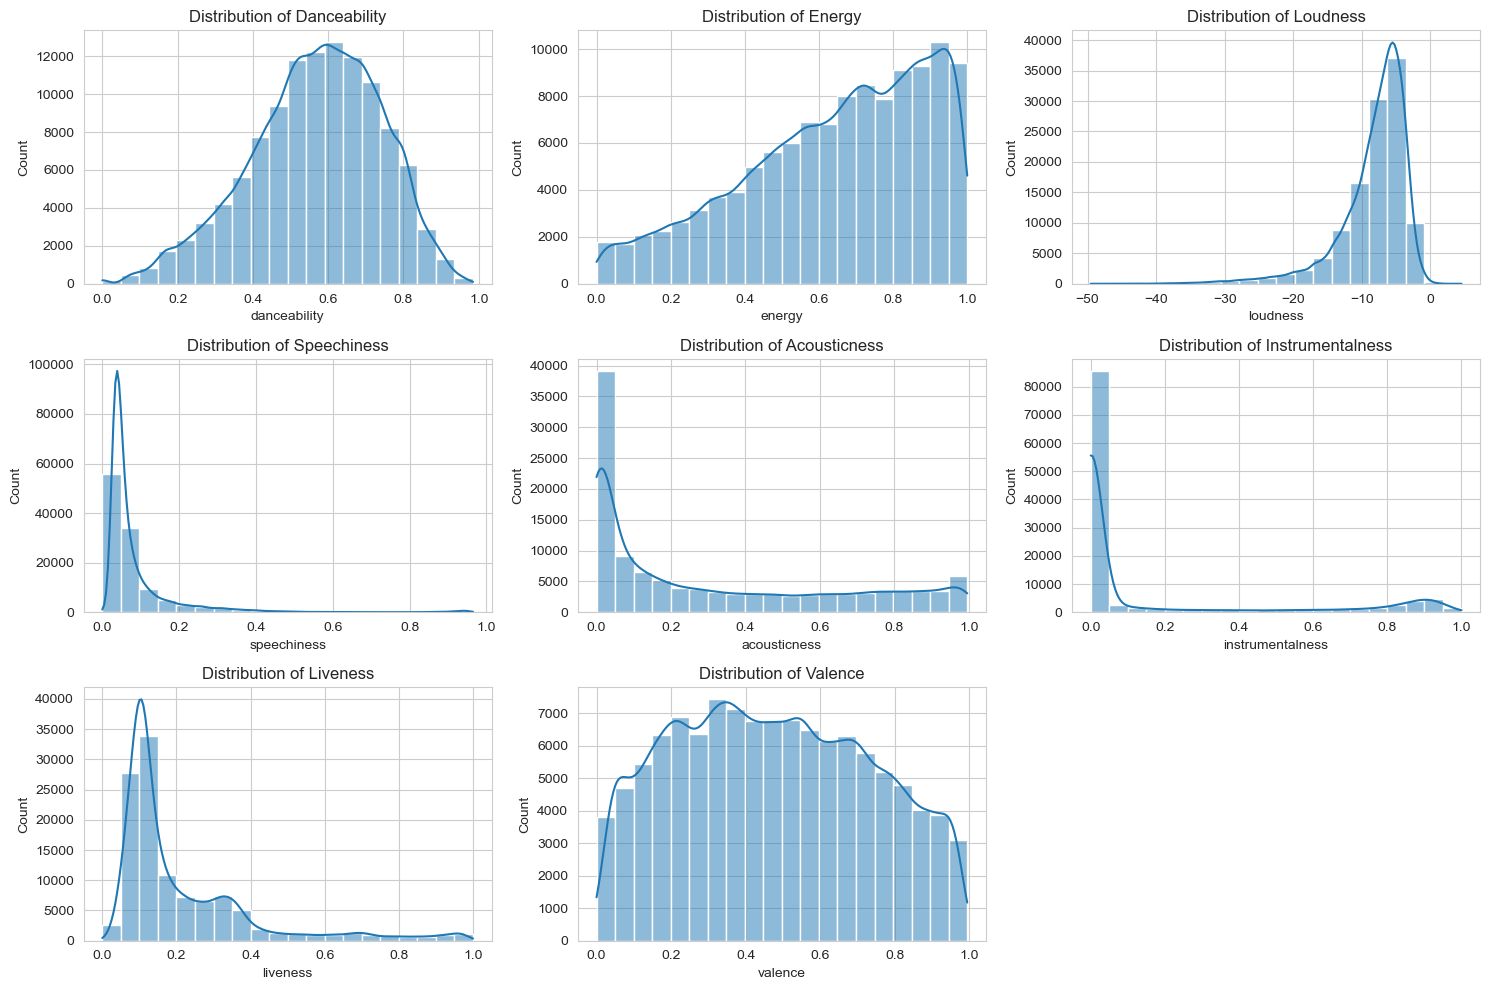


--- EDA: Correlation Heatmap of Audio Features ---


ValueError: could not convert string to float: '5SuOikwiRyPMVoIQDJUgSV'

<Figure size 1000x800 with 0 Axes>

In [3]:
# ----------------------------------------------------
# 1. SETUP AND DATA LOADING
# ----------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap.umap_ as umap # Assuming you have umap-learn installed
import warnings

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Direct link to the raw CSV file on the Hugging Face repository
# This link assumes the file structure hasn't changed.
DATA_URL = "https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/raw/main/spotify_tracks.csv"

print("Loading dataset...")
try:
    df = pd.read_csv("spotify-tracks-dataset/dataset.csv")
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    # Fallback/placeholder if direct URL fails:
    # df = pd.read_csv('spotify_tracks.csv')

# ----------------------------------------------------
# 2. DATA MINING & PREPARATION (Cleaning and Feature Engineering)
# ----------------------------------------------------

# Initial shape and info
print(f"\nInitial Shape: {df.shape}")
df.info()

# Drop irrelevant columns (textual/identifiers not suitable for numeric clustering)
columns_to_drop = ['id', 'name', 'artists', 'album', 'release_date', 'uri', 'track_href', 'analysis_url']
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

# Handle Missing Values (Check for nulls - assuming minimal for this dataset)
print("\nChecking for missing values:")
print(df_cleaned.isnull().sum())
# Simple strategy: Drop rows with any remaining missing values
df_cleaned.dropna(inplace=True)

# Drop duplicates (in case the same track features appear multiple times)
df_cleaned.drop_duplicates(inplace=True)
print(f"\nShape after cleaning: {df_cleaned.shape}")

# Identify the features (audio attributes) for clustering
feature_cols = [col for col in df_cleaned.columns if col not in ['popularity', 'duration_ms', 'time_signature']]
X = df_cleaned[feature_cols]

# ----------------------------------------------------
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ----------------------------------------------------

# --- Distribution of Key Audio Features ---
print("\n--- EDA: Distribution of Key Audio Features ---")
plt.figure(figsize=(15, 10))
for i, col in enumerate(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_cleaned[col], kde=True, bins=20)
    plt.title(f'Distribution of {col.capitalize()}')
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
print("\n--- EDA: Correlation Heatmap of Audio Features ---")
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Audio Features')
plt.show()

# ----------------------------------------------------
# 4. DATA SCALING (Mandatory for Distance-Based Clustering)
# ----------------------------------------------------

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("\nData scaled using StandardScaler.")

# ----------------------------------------------------
# 5. CLUSTERING: K-MEANS
# ----------------------------------------------------

# --- Elbow Method to Find Optimal K ---
print("\n--- Clustering: Elbow Method ---")
inertia = []
# Test K from 1 to 10
k_range = range(1, 3)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster Sum-of-Squares)')
plt.xticks(k_range)
plt.show()

# Based on the elbow plot, choose a value for K (e.g., K=4)
# You should visually inspect the plot to confirm the 'elbow' point.
K_OPT = 4
print(f"Applying K-Means with K = {K_OPT} (based on typical elbow).")

# Apply K-Means with the chosen K
kmeans_final = KMeans(n_clusters=K_OPT, random_state=42, n_init='auto')
clusters = kmeans_final.fit_predict(X_scaled)

# Add cluster labels back to the original dataframe
df_final = df_cleaned.reset_index(drop=True).copy()
df_final['Cluster'] = clusters

# ----------------------------------------------------
# 6. CLUSTER ANALYSIS AND VISUALIZATION (UMAP)
# ----------------------------------------------------

# --- Dimensionality Reduction using UMAP ---
print("\n--- Cluster Visualization: UMAP ---")
# UMAP is generally better at preserving local structure than PCA/t-SNE
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Create a DataFrame for UMAP results
umap_df = pd.DataFrame(X_umap, columns=['UMAP-1', 'UMAP-2'])
umap_df['Cluster'] = clusters

# Plot the UMAP visualization colored by K-Means cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="UMAP-1", y="UMAP-2",
    hue="Cluster",
    palette=sns.color_palette("hsv", K_OPT),
    data=umap_df,
    legend="full",
    alpha=0.6,
    s=50
)
plt.title(f'UMAP Projection of Spotify Tracks Colored by K-Means Clusters (K={K_OPT})')
plt.show()

# --- Cluster Profile Analysis ---
print("\n--- Cluster Profile Analysis: Mean Feature Values ---")
cluster_profiles = df_final.groupby('Cluster')[feature_cols].mean()
print(cluster_profiles.T.round(3))

# Visualize cluster profiles (e.g., using a heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Mean Audio Features per Cluster')
plt.ylabel('Audio Feature')
plt.xlabel('Cluster')
plt.show()

Total tracks with multiple artists: 30075

Network created with 19698 artists (nodes) and 38684 collaborations (edges).
Filtered network has 8089 nodes and 12718 edges.


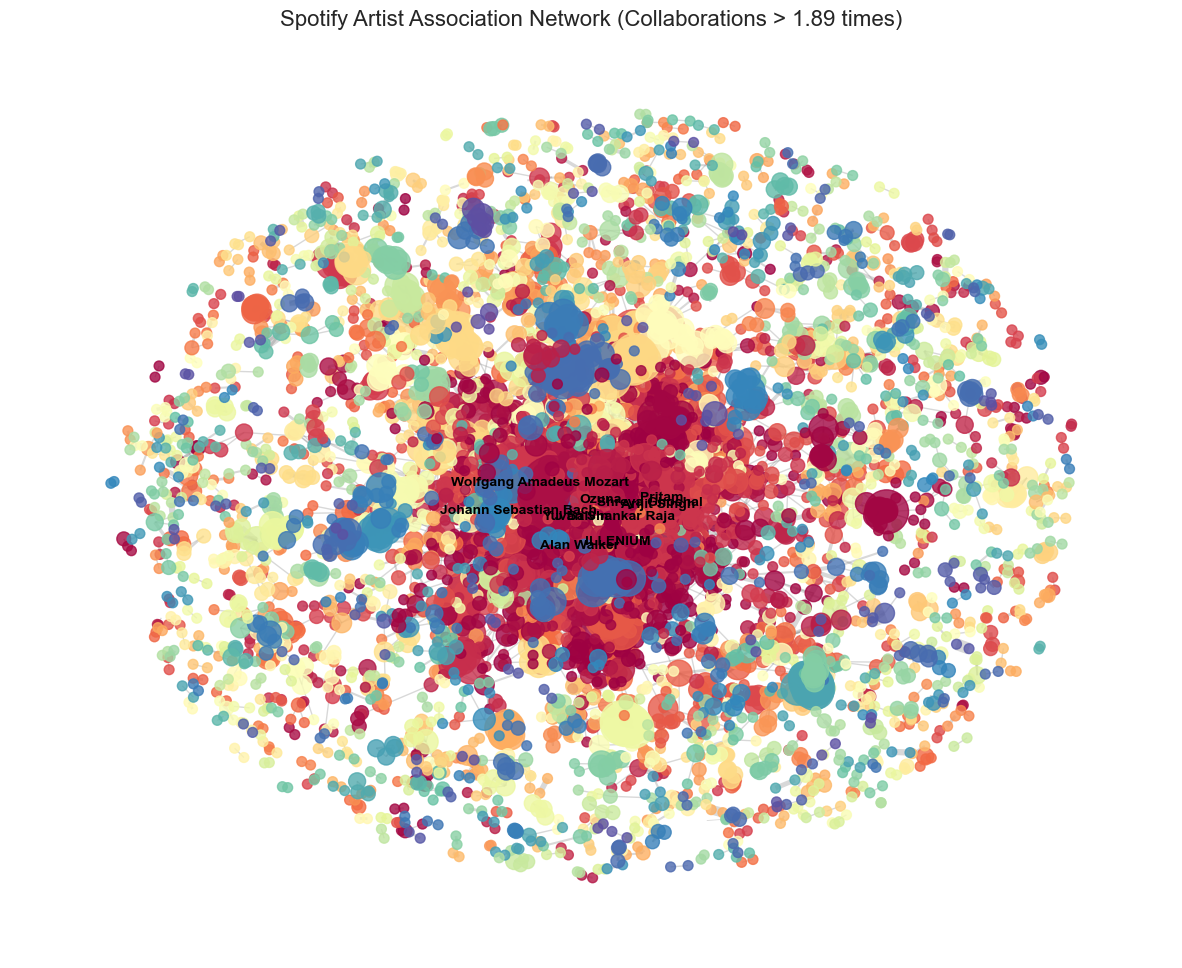

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
#import community as community_louvain # A common library for community detection (optional but helpful)
import community.community_louvain as community_louvain

# Assuming 'df' is your original loaded DataFrame
# (If you ran the previous script, reload or ensure 'df' is available)
# df = pd.read_csv(DATA_URL) 

# ----------------------------------------------------
# 1. DATA PREPARATION: Extracting Co-occurring Artists
# ----------------------------------------------------

# Filter out tracks that only have a single artist, as they don't contribute to associations
multi_artist_tracks = df[df['artists'].str.contains(';', na=False)].copy()

print(f"Total tracks with multiple artists: {multi_artist_tracks.shape[0]}")

# Function to safely split the artist string and strip whitespace
def parse_artists(artist_string):
    if pd.isna(artist_string):
        return []
    # Strip brackets/quotes if present, then split by semicolon
    artists = artist_string.replace("[", "").replace("]", "").replace("'", "").split(';')
    return [artist.strip() for artist in artists if artist.strip()]

# Apply the parsing function to the 'artists' column
multi_artist_tracks['parsed_artists'] = multi_artist_tracks['artists'].apply(parse_artists)

# ----------------------------------------------------
# 2. NETWORK CONSTRUCTION
# ----------------------------------------------------

# Initialize an empty graph
G = nx.Graph()

# Iterate through each track with multiple artists
for index, row in multi_artist_tracks.iterrows():
    artist_list = row['parsed_artists']
    
    # Use itertools.combinations to get all unique pairs of artists in that track
    # This creates the edges (co-appearances)
    for artist1, artist2 in combinations(artist_list, 2):
        
        # Add nodes if they don't exist
        if artist1 not in G:
            G.add_node(artist1)
        if artist2 not in G:
            G.add_node(artist2)
            
        # Add the edge. If it already exists, increment the 'weight' (co-occurrence count)
        if G.has_edge(artist1, artist2):
            G[artist1][artist2]['weight'] += 1
        else:
            G.add_edge(artist1, artist2, weight=1)

print(f"\nNetwork created with {G.number_of_nodes()} artists (nodes) and {G.number_of_edges()} collaborations (edges).")

# ----------------------------------------------------
# 3. NETWORK FILTERING (Optional but Recommended)
# ----------------------------------------------------
# Networks are often too dense to visualize clearly. Let's filter out very weak edges.

# Calculate the mean collaboration weight
mean_weight = sum(nx.get_edge_attributes(G, 'weight').values()) / G.number_of_edges()
weight_threshold = mean_weight 

# Create a filtered graph G_f
G_f = G.copy()
edges_to_remove = [(u, v) for u, v, data in G_f.edges(data=True) if data['weight'] <= weight_threshold]
G_f.remove_edges_from(edges_to_remove)

# Remove any nodes that became isolated after filtering
isolated_nodes = list(nx.isolates(G_f))
G_f.remove_nodes_from(isolated_nodes)

print(f"Filtered network has {G_f.number_of_nodes()} nodes and {G_f.number_of_edges()} edges.")
# ----------------------------------------------------
# 4. NETWORK VISUALIZATION
# ----------------------------------------------------

plt.figure(figsize=(15, 12))

# Use the spring layout for a more natural, clustered look
pos = nx.spring_layout(G_f, k=0.15, iterations=50, seed=42)

# Get edge weights for visualization
edge_weights = [d['weight'] * 0.5 for (u, v, d) in G_f.edges(data=True)]

# Get node degrees (number of collaborations) for node size
node_degrees = dict(G_f.degree())
node_sizes = [v * 50 for v in node_degrees.values()]

# --- Optional: Community Detection (Louvain Algorithm) ---
# This finds groups of artists who collaborate heavily with each other
partition = community_louvain.best_partition(G_f, weight='weight', random_state=42)
node_colors = [partition[node] for node in G_f.nodes()]

# Draw Nodes
nx.draw_networkx_nodes(G_f, pos, 
                       node_size=node_sizes, 
                       node_color=node_colors, 
                       cmap=plt.cm.Spectral,
                       alpha=0.8)

# Draw Edges
nx.draw_networkx_edges(G_f, pos, 
                       width=edge_weights, 
                       alpha=0.3, 
                       edge_color='gray')

# Draw Labels for the most connected artists
# Find the top N nodes by degree
top_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:10]
top_pos = {node: pos[node] for node in top_nodes}
top_labels = {node: node for node in top_nodes}

nx.draw_networkx_labels(G_f, top_pos, 
                        labels=top_labels, 
                        font_size=10, 
                        font_weight='bold', 
                        font_color='black')

plt.title(f"Spotify Artist Association Network (Collaborations > {weight_threshold:.2f} times)", size=16)
plt.axis('off') # Hide the axis
plt.show()

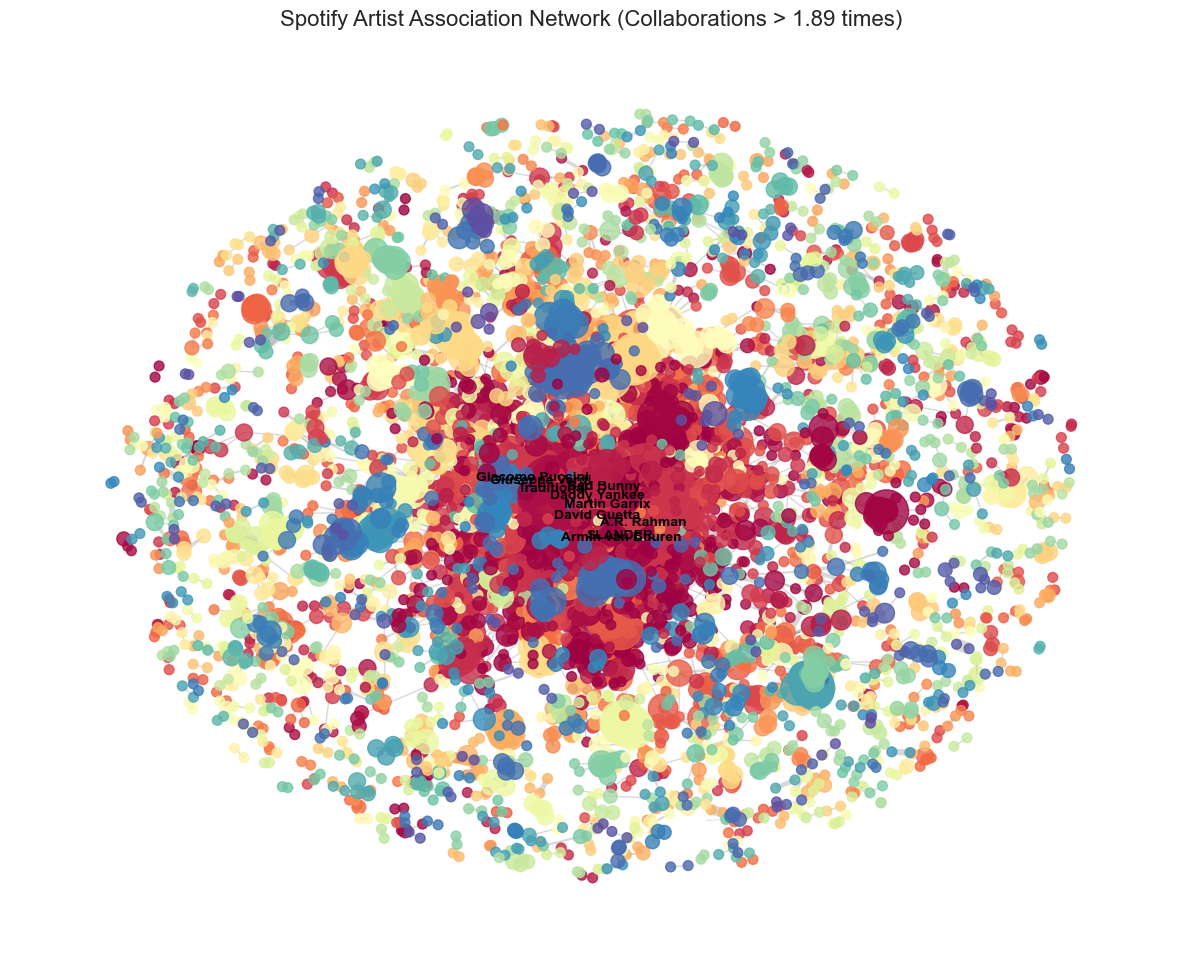

In [9]:

plt.figure(figsize=(15, 12))

# Use the spring layout for a more natural, clustered look
pos = nx.spring_layout(G_f, k=0.15, iterations=50, seed=42)

# Get edge weights for visualization
edge_weights = [d['weight'] * 0.5 for (u, v, d) in G_f.edges(data=True)]

# Get node degrees (number of collaborations) for node size
node_degrees = dict(G_f.degree())
node_sizes = [v * 50 for v in node_degrees.values()]

# --- Optional: Community Detection (Louvain Algorithm) ---
# This finds groups of artists who collaborate heavily with each other
partition = community_louvain.best_partition(G_f, weight='weight', random_state=42)
node_colors = [partition[node] for node in G_f.nodes()]

# Draw Nodes
nx.draw_networkx_nodes(G_f, pos, 
                       node_size=node_sizes, 
                       node_color=node_colors, 
                       cmap=plt.cm.Spectral,
                       alpha=0.8)

# Draw Edges
nx.draw_networkx_edges(G_f, pos, 
                       width=edge_weights, 
                       alpha=0.3, 
                       edge_color='gray')

# Draw Labels for the most connected artists
# Find the top N nodes by degree
top_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[10:20]
top_pos = {node: pos[node] for node in top_nodes}
top_labels = {node: node for node in top_nodes}

nx.draw_networkx_labels(G_f, top_pos, 
                        labels=top_labels, 
                        font_size=10, 
                        font_weight='bold', 
                        font_color='black')

plt.title(f"Spotify Artist Association Network (Collaborations > {weight_threshold:.2f} times)", size=16)
plt.axis('off') # Hide the axis
plt.show()

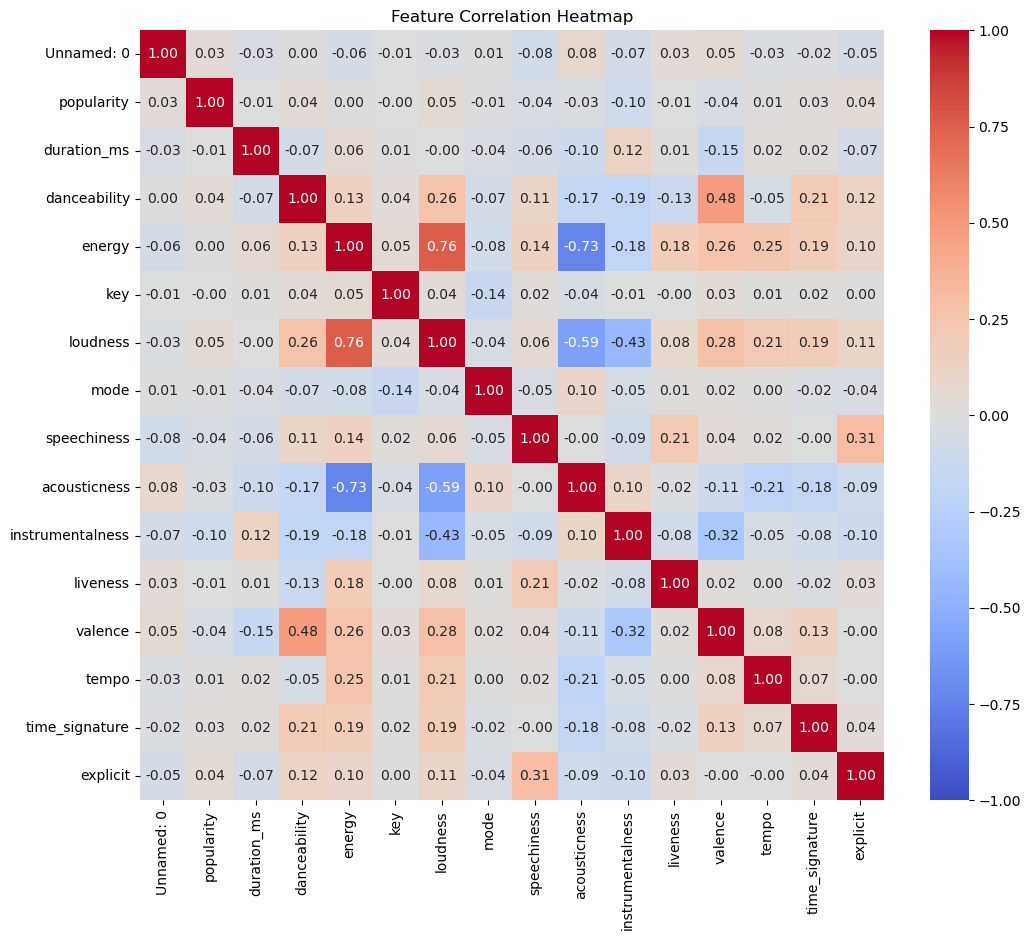

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the dataset
# Replace 'your_dataset.csv' with your actual file path
df = pd.read_csv('spotify-tracks-dataset/dataset.csv')

# 2. Preprocess the data
# Select only numeric columns for correlation analysis.
# This automatically excludes strings like 'artists', 'album_name', 'track_genre', etc.
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# The 'explicit' column is boolean (True/False). We can convert it to 0/1 to include it.
if 'explicit' in df.columns:
    numeric_df['explicit'] = df['explicit'].astype(int)

# 3. Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# 4. Visualize the correlation matrix using a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Load the dataset
df = pd.read_csv('spotify-tracks-dataset/dataset.csv')

# 2. Preprocess: Convert boolean 'explicit' to int if it exists
if 'explicit' in df.columns:
    df['explicit'] = df['explicit'].astype(int)

# 3. Get list of all unique genres
unique_genres = df['track_genre'].unique()

# Optional: Create a directory to store the many images
output_folder = 'genre_heatmaps'
os.makedirs(output_folder, exist_ok=True)

# 4. Iterate through each genre
for genre in unique_genres:
    # Filter the dataframe for the current genre
    genre_df = df[df['track_genre'] == genre]
    
    # Keep only numeric columns for correlation
    numeric_genre_df = genre_df.select_dtypes(include=['float64', 'int64'])
    
    # Calculate correlation matrix
    corr_matrix = numeric_genre_df.corr()
    
    # Check if there is enough data to plot (optional safety check)
    if not corr_matrix.empty:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
        
        plt.title(f'Correlation Heatmap - Genre: {genre}')
        plt.tight_layout()
        
        # Save the plot to a file instead of showing it (to avoid 100+ popups)
        # Sanitize filename to remove characters that might break file paths (like /)
        safe_filename = "".join([c for c in genre if c.isalpha() or c.isdigit() or c==' ']).rstrip()
        plt.savefig(f'{output_folder}/heatmap_{safe_filename}.png')
        
        # Clear the figure to free memory
        plt.close()

print(f"All heatmaps have been saved to the '{output_folder}' folder.")

All heatmaps have been saved to the 'genre_heatmaps' folder.


C:\Users\cswor\AppData\Local\Temp\ipykernel_20892\1001774069.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='track_genre', y='energy', data=df_filtered, palette='Set3')


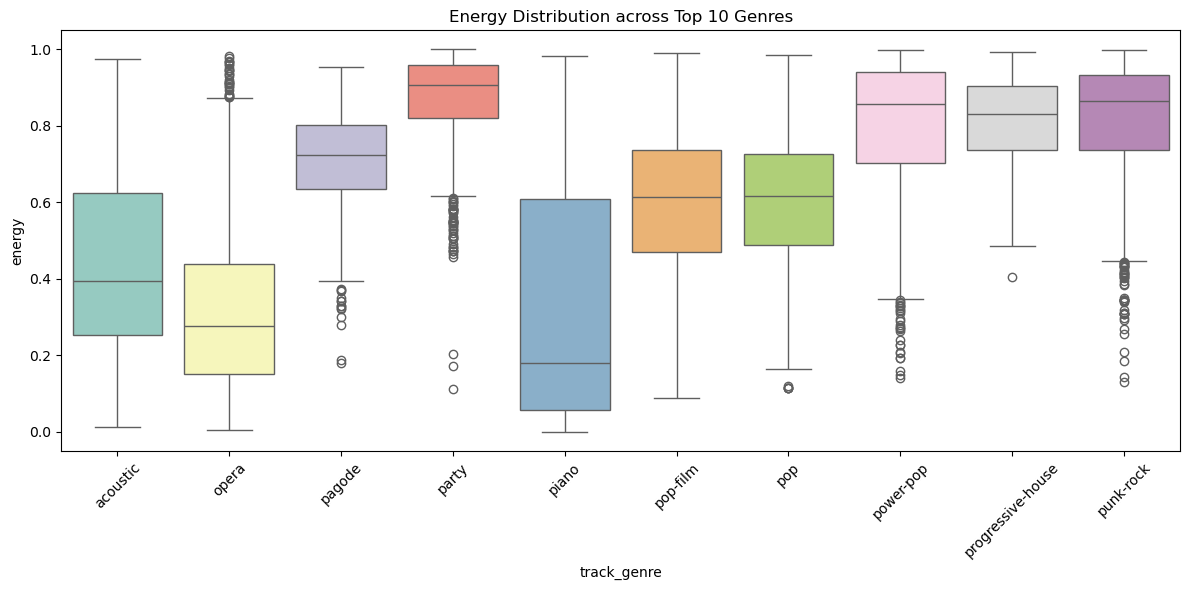

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for the top 10 most frequent genres to keep the chart readable
top_genres = df['track_genre'].value_counts().nlargest(10).index
df_filtered = df[df['track_genre'].isin(top_genres)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='track_genre', y='energy', data=df_filtered, palette='Set3')

plt.title('Energy Distribution across Top 10 Genres')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

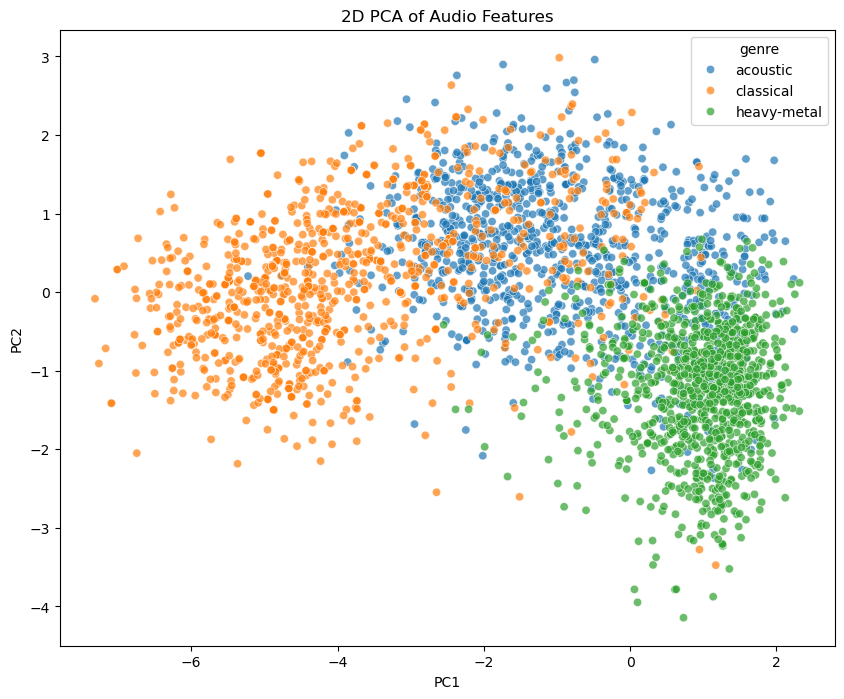

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Select features and standardize them (crucial for PCA)
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo']
x = df.dropna()[features] # Drop NA to prevent errors
x_scaled = StandardScaler().fit_transform(x)

# 2. Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_scaled)
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# 3. Add genre back for coloring
pca_df['genre'] = df.dropna()['track_genre'].values

# 4. Plot - filtering for just a few genres to see the separation clearly
target_genres = ['acoustic', 'heavy-metal', 'classical']
subset = pca_df[pca_df['genre'].isin(target_genres)]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='genre', data=subset, alpha=0.7)
plt.title('2D PCA of Audio Features')
plt.show()

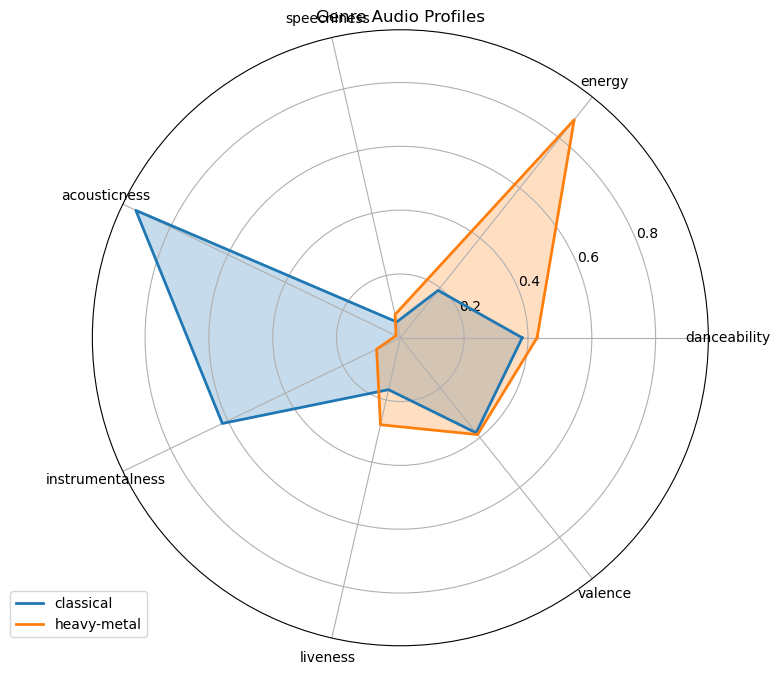

In [8]:
import numpy as np

# Select features to plot (values must be roughly same scale, 0-1 works best)
# Note: Loudness/Tempo are not 0-1, so we exclude them or normalize them first.
features = ['danceability', 'energy', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence']

target_genres = ['classical', 'heavy-metal']
means = df.groupby('track_genre')[features].mean().loc[target_genres]

# Setup for Radar Chart
categories = list(means.columns)
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

for genre in target_genres:
    values = means.loc[genre].tolist()
    values += values[:1] # Close the loop
    ax.plot(angles, values, linewidth=2, label=genre)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title("Genre Audio Profiles")
plt.show()